In [210]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from skimage.feature import hog
import pandas as pd
%matplotlib inline

# Feature Extraction

### Load Data

In [2]:
vehicles_filenames = glob.glob('data/vehicles/*/*.png')
non_vehicles_filenames = glob.glob('data/non-vehicles/*/*.png')
print("Number of Vehicles Images: {}".format(len(vehicles_filenames)))
print("Number of Non-Vehicles Images: {}".format(len(non_vehicles_filenames)))

Number of Vehicles Images: 8792
Number of Non-Vehicles Images: 8968


### Data Visualization

In [3]:
random_vehicle_index = np.random.randint(0, len(vehicles_filenames))
random_non_vehicle_index = np.random.randint(0, len(non_vehicles_filenames))

vehicle_example = cv2.imread(vehicles_filenames[random_vehicle_index])
vehicle_example = cv2.cvtColor(vehicle_example, cv2.COLOR_BGR2RGB)
non_vehicle_example = mpimg.imread(non_vehicles_filenames[random_non_vehicle_index])
non_vehicle_example = cv2.cvtColor(non_vehicle_example, cv2.COLOR_BGR2RGB)

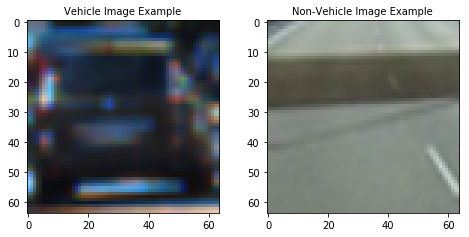

In [4]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 9))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image Example', fontsize=10)
ax2.imshow(non_vehicle_example)
ax2.set_title('Non-Vehicle Image Example', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline Definition

### Bin Spatial

In [5]:
# Resize images to 32x32 pixels
def bin_spatial(img, size=(32, 32), vis=False):
    
    if not vis:
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    else:
        img = cv2.resize(img, size)
        features = img.ravel() 
        #Return the feature vector and the image for visualization
        return features, img

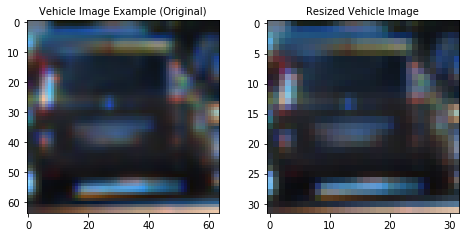

In [6]:
_, vehicle_example_bin = bin_spatial(vehicle_example, vis=True)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 9))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image Example (Original)', fontsize=10)
ax2.imshow(vehicle_example_bin)
ax2.set_title('Resized Vehicle Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Histogram 

In [24]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], nbins, bins_range)
    ghist = np.histogram(img[:,:,1], nbins, bins_range)
    bhist = np.histogram(img[:,:,2], nbins, bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Text(0.5,1,'B Histogram')

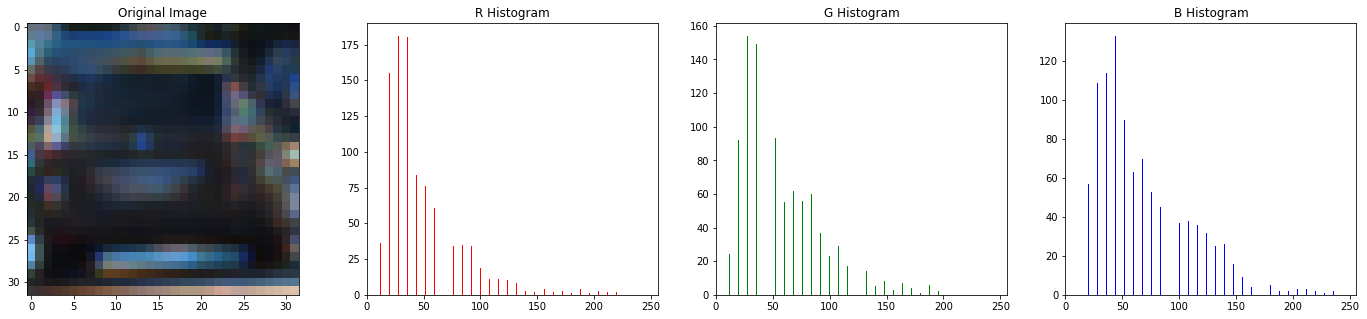

In [35]:
rhist, ghist, bhist, bin_centers, hist_features = color_hist(vehicle_example_bin)


# Plot a figure with all three bar charts
fig = plt.figure(figsize=(24,5))
plt.subplot(141)
plt.imshow(vehicle_example_bin)
plt.title('Original Image')
plt.subplot(142)
plt.bar(bin_centers, rhist[0], color='r')
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(143)
plt.bar(bin_centers, ghist[0], color='g')
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(144)
plt.bar(bin_centers, bhist[0], color='b')
plt.xlim(0, 256)
plt.title('B Histogram')

### Exploring Color Spaces

In [99]:
#Capture 3 images from Vehicles and Non-Vehicles
CS_vehicles = []

def cvt_color(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image) 
    return feature_image

for i in range(0,3):
    random_vehicle = np.random.randint(0, len(vehicles_filenames))
    img = cv2.imread(vehicles_filenames[random_vehicle])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    CS_vehicles.append(img)

    img_cvt = cvt_color(img, 'HSV')
    CS_vehicles.append(img_cvt)

for i in range(0,3):
    random_non_vehicle = np.random.randint(0, len(non_vehicles_filenames))
    img1 = cv2.imread(non_vehicles_filenames[random_non_vehicle])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    CS_vehicles.append(img1)

    img1_cvt = cvt_color(img1, 'HSV')
    CS_vehicles.append(img1_cvt)
    
CS_vehicles = np.asarray(CS_vehicles)

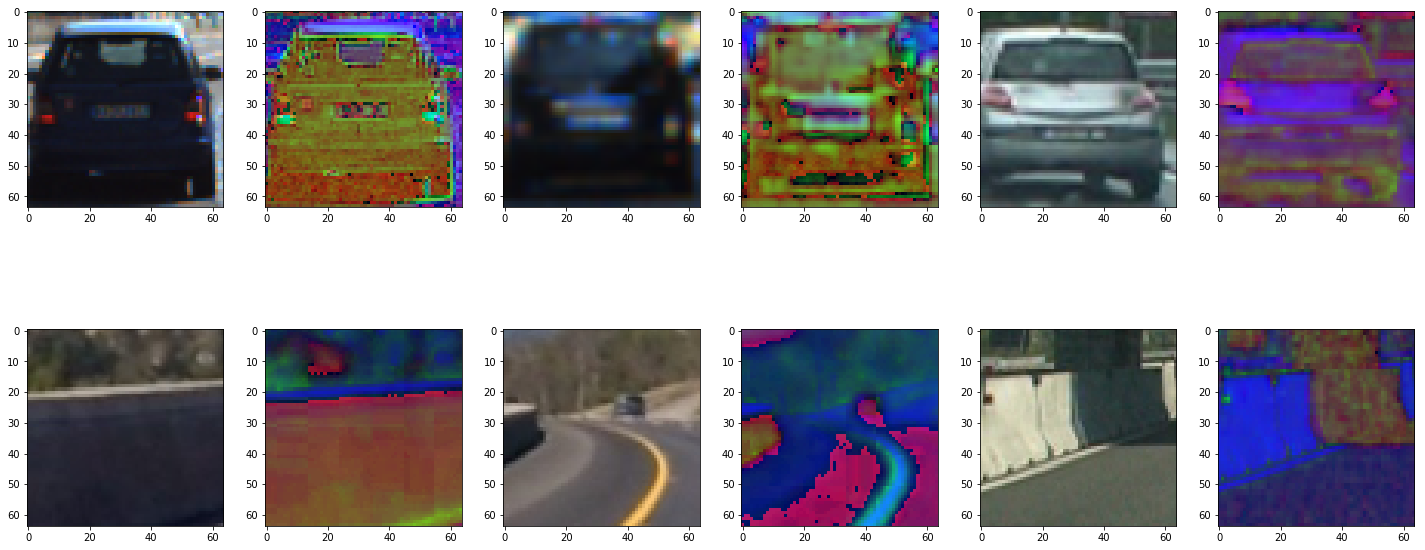

In [100]:
# Plot the result
f, ax = plt.subplots(2, 6, figsize=(20,9))
f.tight_layout()
for i in range(0,2): 
    for j in range(0,6):
        teste = (i*6)+j
        ax[i,j].imshow(CS_vehicles[(i*6)+j])

HSV looks like the cars are highlighted, so we'll stick with this option.

### HOG

In [107]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

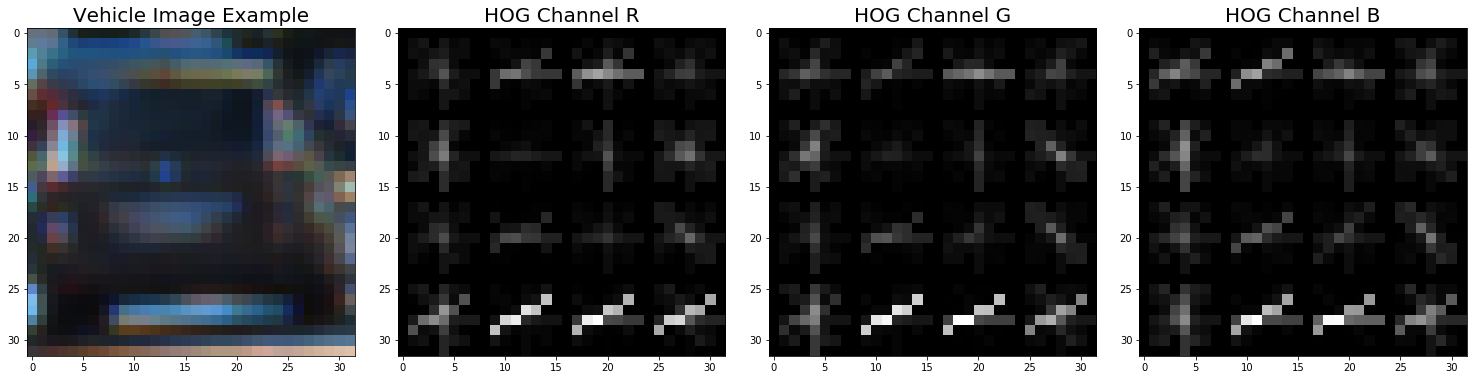

In [128]:
vehicle_hog = []
for channel in range(0, 3):
    _, vehicle_example_hog = get_hog_features(vehicle_example_bin[:,:,channel], orient = 8, pix_per_cell = 8, cell_per_block = 2, vis=True)
    vehicle_hog.append(vehicle_example_hog)
# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 9))
f.tight_layout()
ax1.imshow(vehicle_example_bin)
ax1.set_title('Vehicle Image Example', fontsize=20)
ax2.imshow(vehicle_hog[0], cmap='gray')
ax2.set_title('HOG Channel R', fontsize=20)
ax3.imshow(vehicle_hog[1], cmap='gray')
ax3.set_title('HOG Channel G', fontsize=20)
ax4.imshow(vehicle_hog[2], cmap='gray')
ax4.set_title('HOG Channel B', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Final Pipeline

In [129]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        img = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        feature_image = cvt_color(img, cspace)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() to get color histogram features
        _,_,_,_,color_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply get_hog_features() to get HOG features
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, color_features, hog_features)))
    # Return list of feature vectors
    return features

### Hyperparameter selection

In [142]:
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

### Final step for feature extraction

In [145]:
vehicles_features = extract_features(vehicles_filenames, cspace=colorspace, spatial_size=spatial_size,
                                     hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
non_vehicles_features = extract_features(non_vehicles_filenames, cspace=colorspace, spatial_size=spatial_size,
                                         hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

In [150]:
# Create an array stack of feature vectors
X = np.vstack((vehicles_features, non_vehicles_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(non_vehicles_features))))

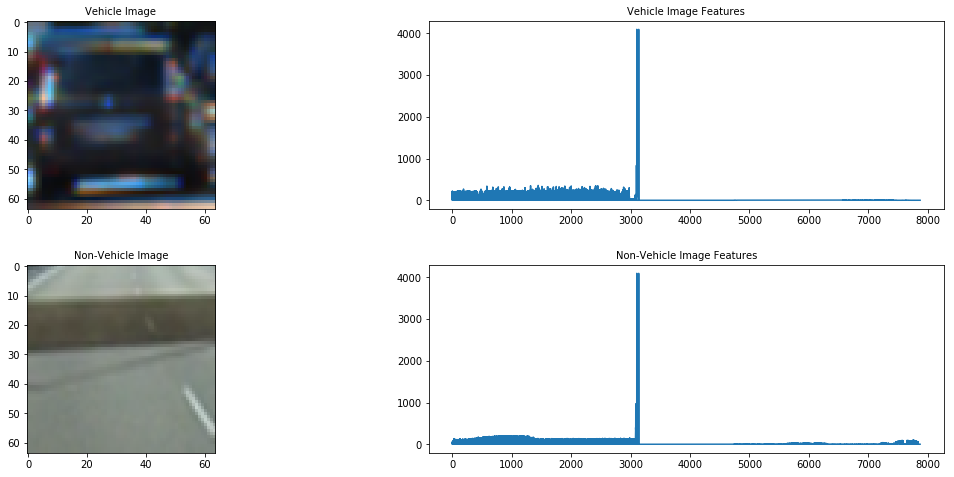

In [209]:
# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 4))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image', fontsize=10)
ax2.plot(X[random_vehicle_index])
ax2.set_title('Vehicle Image Features', fontsize=10)
ax3.imshow(non_vehicle_example)
ax3.set_title('Non-Vehicle Image', fontsize=10)
ax4.plot(X[len(vehicles_features) + random_non_vehicle_index])
ax4.set_title('Non-Vehicle Image Features', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=1.5, bottom=0.)

#### Saving data to .csv

In [154]:
np.savetxt('features.csv', X, delimiter=',')
np.savetxt('labels.csv', y, delimiter=',')

## Classification

In [224]:
X = np.asarray(pd.read_csv('features.csv', sep=',', header=None))
y = np.squeeze(np.asarray(pd.read_csv('labels.csv', sep=',', header=None)))